In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.formula.api as smf
import cryptofxns
import os
from os import listdir
from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
hap_filter_size = 6000
HAPFILTINT = int(hap_filter_size/1000.0)
Method = '-min'
fileendname = Method +'-haplotype-k' + str(int(hap_filter_size)) + '.csv'

In [3]:
#genodf = pd.read_csv('../FILES/FiltGenotoHapFiltGeno2017-02-22.csv',index_col=0);print genodf.shape
#genodf = pd.read_csv('../FILES/FiltGenotoHapFiltGeno-min-Geno-k6000.csv');print genodf.shape
file_end = 'min-Geno-k6000.csv'## JUN 15th
genodf = pd.read_csv('../FILES/FiltGenotoHapFiltGeno-%s'%file_end)
centromere = cryptofxns.load_centrom_locs()
clens = cryptofxns.chromosome_lengths
tc = cryptofxns.thecol

In [4]:
chrom_num = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV'];

In [5]:
chrlist = sorted(np.unique(genodf.Chrom).tolist())
segs_parents = genodf.columns.tolist()[tc:];
#segs_all = [s for s in segs_parents if s not in cryptofxns.geno_remove];len(segs_all)
segs_all = [s for s in segs_parents ]

## PATCH Jan 2018
At some point in time we changed the names of the "corrected" strains. Here I need to change them back to match teh file names we have. 

In [6]:
old_names = []
for seg in segs_all:
    if len(seg) > len(segs_all[0]):
        new_name = seg.split('_')[0] + '_cor'
        old_names.append(new_name)
    else:
        old_names.append(seg)

In [7]:
segs_all = old_names

In [8]:
FILECHRPATHS = cryptofxns.FILECHRPATHS;
HAPFILES = [f[2] for f in FILECHRPATHS];

In [9]:
HAPFILES[0]

'../FILES/CHR1/HAP/'

In [10]:
len(segs_all)

94

In [11]:
hapdfs = [];
for ch, chrom in enumerate(chrlist):
    dfs = []
    for seg in segs_all:
        path = HAPFILES[ch] + seg + '/' + seg + fileendname
        if os.path.exists(path):
            dfs.append(pd.read_csv(path))
    hapdfs.append(dfs)

In [12]:
def set_colors(gt,cl = ['lightblue','orange']):
    colors = []
    for i in gt:
        if i == 0:
            colors.append(cl[0]);
        else:
            colors.append(cl[1]);
    return colors

In [13]:
len(hapdfs[0])

94

## Calculate SNP Density Along each chromosome

In [14]:
clens[3]/10000.0

178.3051

In [15]:
sub = genodf[genodf.Chrom == 'Chr03']

In [16]:
sub.shape

(8897, 98)

In [17]:
clens[2]/1000000.

2.105722

In [18]:
ws = 10e3;
windows = range(0,int(clens[2]+ws),int(ws));
Nsnps = []
for i in range(len(windows)-1):
    Nsnps.append(len(sub.Pos[(sub.Pos >= windows[i])&(sub.Pos <= windows[i+1])]))

In [19]:
len(Nsnps)

211

In [20]:
len(Nsnps);print max(Nsnps)

125


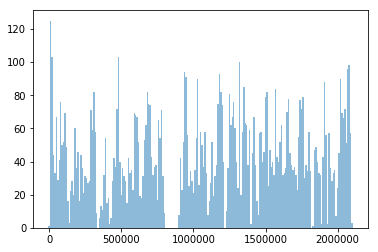

In [21]:
#plt.plot(windows[:-1],Nsnps,'-');
plt.bar(windows[:-1],Nsnps,width=ws,alpha=.5);

In [22]:
len(windows)

212

In [23]:
windows[-5:]

[2070000, 2080000, 2090000, 2100000, 2110000]

## For each chromosome, window calculate SNP density

In [24]:
chromNsnps = [];ws = 10e3;chromNwins = [];
for ch,chrom in enumerate(chrlist):
    sub = genodf[genodf.Chrom == chrom];Nsnps = [];
    windows = range(0,int(clens[ch]+ws),int(ws));
    for i in range(len(windows)-1):
        Nsnps.append(len(sub.Pos[(sub.Pos >= windows[i])&(sub.Pos <= windows[i+1])]));
    chromNsnps.append(Nsnps);chromNwins.append(windows);

In [25]:
import math
def my_round(N,myadd=0,myden=100.0):
    return math.ceil((N + myadd)/myden) * myden

## Recombination fraction for each chromosome

## Bring in CO x IMI dataframe

In [26]:
hotIMIdf = pd.read_csv('../FILES/Crypto-Genome-IMIxCO-%s'%file_end)

In [27]:
hotIMIdf.head()

,Chrom,W,V,IMI,XO,uXO,bXO,Pos
0,Chr01,5016.0,5299.0,282,0.0,0.0,0.0,5157.5
1,Chr01,5299.0,5464.0,164,0.0,0.0,0.0,5381.5
2,Chr01,5464.0,6120.0,655,0.0,0.0,0.0,5792.0
3,Chr01,6120.0,6166.0,45,0.0,0.0,0.0,6143.0
4,Chr01,6166.0,6477.0,310,0.0,0.0,0.0,6321.5


In [28]:
hotIMIdfbi = hotIMIdf[['Chrom','W','V','IMI','bXO','Pos']];
hotIMIdfbi.columns = ['Chrom','W','V','IMI','XO','Pos'];#pd.read_csv('../FILES/Crypto-Genome-Hotspots-bi-Mar2017',index_col=0)
hotIMIdfun = hotIMIdf[['Chrom','W','V','IMI','uXO','Pos']];
hotIMIdfun.columns = ['Chrom','W','V','IMI','XO','Pos'];#pd.read_csv('../FILES/Crypto-Genome-Hotspots-un-Mar2017',index_col=0)

In [29]:
hotIMIdfbi.head()

,Chrom,W,V,IMI,XO,Pos
0,Chr01,5016.0,5299.0,282,0.0,5157.5
1,Chr01,5299.0,5464.0,164,0.0,5381.5
2,Chr01,5464.0,6120.0,655,0.0,5792.0
3,Chr01,6120.0,6166.0,45,0.0,6143.0
4,Chr01,6166.0,6477.0,310,0.0,6321.5


In [30]:
subbi = hotIMIdfbi[hotIMIdfbi.Chrom=='Chr07'];
subun = hotIMIdfun[hotIMIdfun.Chrom=='Chr07'];
print subbi.shape
print subun.shape
subbi_rf = [subbi.XO[i]/(39*float(subbi.IMI[i])) for i in subbi.index.tolist()]
subbi_pos = subbi.Pos#[np.median([subbi.W[i],subbi.V[i]]) for i in subbi.index.tolist()]
subun_rf = [subun.XO[i]/(55*float(subun.IMI[i])) for i in subun.index.tolist()]
subun_pos = subun.Pos#[np.median([subun.W[i],subun.V[i]]) for i in subun.index.tolist()]

(5867, 6)
(5867, 6)


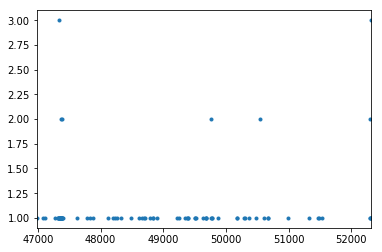

In [31]:
subun.XO[subun.XO>0].plot(marker='.',linestyle='None');

In [32]:
subun[subun.XO > 40]

,Chrom,W,V,IMI,XO,Pos


In [33]:
(50/55.0) * 100 

90.9090909090909

In [34]:
len(subun.IMI)

5867

In [35]:
sorted(subun.IMI,reverse=True)[:10]

[12649, 6713, 6405, 5905, 4697, 4173, 4059, 3898, 3662, 3066]

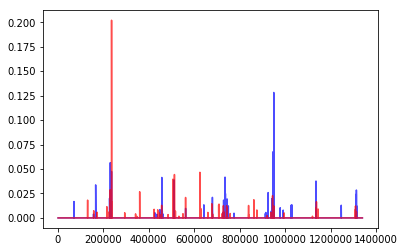

In [36]:
plt.plot(subbi_pos,np.array(subbi_rf)*100,'b',alpha=.7);
plt.plot(subun_pos,np.array(subun_rf)*100,'r',alpha=.7);

In [37]:
max(subbi_rf)*100

0.12820512820512819

In [38]:
my_round(max(subbi_rf)*100)

100.0

In [39]:
mats = 1529240
matst = 1661861

In [40]:
len(hapdfs[0])

94

## PATCH Jan2018
This makes sure we are using the same segregatns as the original figure used in submission

In [41]:
segs_iused = ['SS-B314',
 'SS-B399',
 'SS-B374',
 'SS-B383',
 'SS-B356',
 'SS-B926',
 'SS-B930',
 'SS-B997',
 'SS-C039',
 'SS-C271']

In [42]:
segs = segs_iused

In [43]:
segs_all.index('SS-B997')

80

In [44]:
for seg in segs:
    print segs_all.index(seg)

6
29
21
25
12
71
74
80
88
90


In [45]:
len(hapdfs[1])

94

In [46]:
chrlist[:3]

['Chr01', 'Chr02', 'Chr03']

In [47]:
np.arange(0,200,50)

array([  0,  50, 100, 150])

In [48]:
np.arange(0,20,4)

array([ 0,  4,  8, 12, 16])

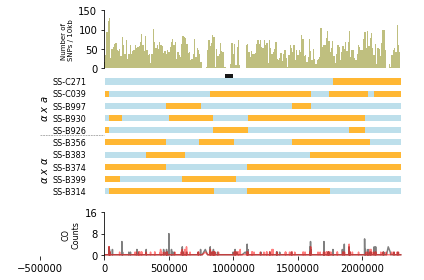

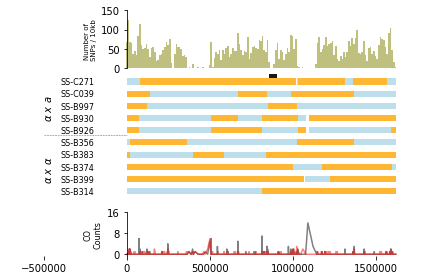

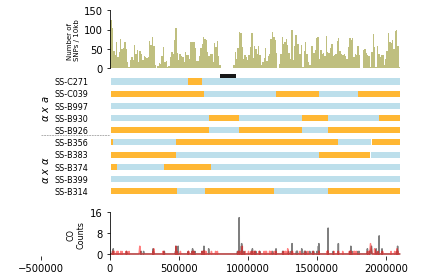

In [49]:
for ch, chrom in enumerate(chrlist[:3]):
    fig = plt.figure(figsize=(6,4));mod = 1;
    gs = gridspec.GridSpec(3,1, height_ratios=[.4,1,.3]);
    ax1 = fig.add_subplot(gs[0]);
    ## SNP DENSITY 
    ax1.bar(chromNwins[ch][:-1],chromNsnps[ch],width=ws,alpha=.5,color='olive');
    ax1.set_ylabel('Number of \nSNPs / %skb'%int(ws/1e3),fontsize=7);
    ax1.set_yticks(np.arange(0,200,50))
    #ax1.set_ylim(0,)
    #SNP_max = my_round(max(chromNsnps[ch]));
    #assert SNP_max > max(chromNsnps[ch])
    #ax1.set_ylim(-1,SNP_max+50);
    ax1.spines['left'].set_position(('data', 0))
    ax = fig.add_subplot(gs[1])
    #ax.broken_barh([(0,200000)],(0,1),facecolors='r',alpha=.7);
    #ax.annotate('200kb',(0,-1.5),fontsize=8);
    for s, Seg in enumerate(segs):
        seg = hapdfs[ch][segs_all.index(Seg)]
        x = zip(seg.v.tolist(),[nbs - 1 for nbs in seg.nb.tolist()]);
        fcolors = set_colors(seg.genotype.tolist());
        ax.annotate(Seg,(-400000,s+mod),fontsize=8) ## The Names of each segregant
        ax.broken_barh(x,[s+mod,1],facecolors=fcolors,alpha=.8);
        if s == 4: ## if you change the number of segregants in each plot you need to alter these
            ax.hlines(s+mod+1.65,-500000,0,linestyles='--',linewidth=.5,alpha=.6)
        if s == 2:
            ax.annotate(r'$\alpha\  x\  \alpha$',(-500000,s+mod+1),rotation='vertical')
        if s == 7:
            ax.annotate(r'$\alpha\  x\  a$',(-500000,s+mod+1),rotation='vertical')
        mod = mod +1;
    ## PLOT CENTROMERE
    ax.broken_barh([(centromere[0][chrom],
                      centromere[1][chrom]-centromere[0][chrom])],
                    (s+mod,0.7),
                    facecolors='black',alpha =.9);
    ## PLOT MAT LOCUS
    if ch == 3:
        ax.broken_barh([(mats,
                      matst-mats)],
                    (s+mod,0.6),
                    facecolors='g',alpha =.9);
    ax2 = fig.add_subplot(gs[2])
    subbi = hotIMIdfbi[hotIMIdfbi.Chrom==chrom];
    subun = hotIMIdfun[hotIMIdfun.Chrom==chrom];
    bis = 1#39.0;
    uns=1#55.0
    subbi_rf = [int(subbi.XO[i])/float(bis) for i in subbi.index.tolist()]#[100*(subbi.XO[i]/bis)/float(subbi.IMI[i]) for i in subbi.index.tolist()]
    subbi_pos = subbi.Pos#[np.median([subbi.W[i],subbi.V[i]]) for i in subbi.index.tolist()]
    subun_rf = [int(subun.XO[i])/float(uns) for i in subun.index.tolist()]#[100*(subun.XO[i]/uns)/float(subun.IMI[i]) for i in subun.index.tolist()]
    subun_pos = subun.Pos#[np.mean([subun.W[i],subun.V[i]]) for i in subun.index.tolist()]
    ax2.plot(subbi_pos,subbi_rf,'k',alpha=.5);
    ax2.plot(subun_pos,subun_rf,'r',alpha=.5);
    #ax2.set_ylim(0,1);
    #ax2.set_ylim(0,max([max(subbi_rf),max(subun_rf)])+1);
    ax2.spines['left'].set_position(('data', 0))
    major_ticks = np.arange(0,max([max(subbi_rf),max(subun_rf)]),4);
    #ax2.set_yticks(major_ticks);
    ax2.set_ylabel('CO\nCounts',fontsize=8);
    ax2.set_yticks(np.arange(0,20,8))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
    ax.set_ylim(-2,);
    ax.set_xlim(-600000,clens[ch]+100000);
    ax1.set_xlim(-600000,clens[ch]+100000);
    ax2.set_xlim(-600000,clens[ch]+100000);
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax.axis('off')
    ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 
    #ax2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
    plt.tight_layout();
    gs.update(wspace=0.001,hspace=0.0001)
    ##fig.savefig('../FIGS/Crypto-Wood-Floor-10-%s-k1-6kb-Aug2017.png'%chrom,dpi=600)

# Plot woodfloor plots for each segregant

In [50]:
segs_all = sorted(segs_all)

In [51]:
axalp = np.concatenate([['SS-B869_cor', 'SS-B872_cor', 'SS-B873_cor', 'SS-B874_cor'], # 1
         ['SS-B876', 'SS-B880','SS-B879', 'SS-B885'], #2## SS-B885 and B879 are identical, except chrom 4 and disomic on chrom 10
         ['SS-B886_cor', 'SS-B887_cor'],#3
         ['SS-B890_cor', 'SS-B896_cor', 'SS-B898_cor', 'SS-B892_cor',#4 ## SS-B892_cor 58.5% like SS-B930
         'SS-B901_cor', 'SS-B905', 'SS-B906_cor', 'SS-B908_cor'],#4
        ['SS-B926', 'SS-B927', 'SS-B929', 'SS-B930'],#5
         ['SS-B952', 'SS-B956'],#6
         ['SS-B960_cor', 'SS-B961_cor'],#7 ## SS-B960_cor
        ['SS-B996', 'SS-B997', 'SS-B998'],#8
        ['SS-C001'],#9
        ['SS-C026_cor', 'SS-C029_cor'],#10
        ['SS-C031_cor'],#11
        ['SS-C033', 'SS-C036', 'SS-C039'],#12
        ['SS-C242'],#13
        ['SS-C271', 'SS-C272'],#14
        ['SS-C273'],#15
        ['SS-C290', 'SS-C291']])#16

In [52]:
seg_un = [];seg_bi = []
for seg in segs_all:
    if seg in axalp:
        seg_bi.append(seg)
    else:
        assert (seg not in axalp)
        seg_un.append(seg)

In [53]:
len(seg_un)

55

In [54]:
len(seg_bi)

39

In [55]:
segs_all_s = np.concatenate([seg_un,seg_bi])

for ch, chrom in enumerate(chrlist):
    fig = plt.figure(figsize=(6,36));mod = 1;
    gs = gridspec.GridSpec(3,1, height_ratios=[.1,1,.1]);
    ax1 = fig.add_subplot(gs[0]);
    ## SNP DENSITY 
    ax1.bar(chromNwins[ch][:-1],chromNsnps[ch],width=ws,alpha=.5,color='olive');
    ax1.set_ylabel('Number of \nSNPs / %skb'%int(ws/1e3),fontsize=7);
    #ax1.set_ylim(0,)
    #SNP_max = my_round(max(chromNsnps[ch]));
    #assert SNP_max > max(chromNsnps[ch])
    #ax1.set_ylim(-1,SNP_max+50);
    ax1.spines['left'].set_position(('data', 0))
    ax = fig.add_subplot(gs[1])
    ax.broken_barh([(0,200000)],(0,1),facecolors='r',alpha=.7);
    ax.annotate('200kb',(0,-1.5),fontsize=8);
    for s, Seg in enumerate(seg_un): ## What you are ploting
        seg = hapdfs[ch][segs_all.index(Seg)]
        x = zip(seg.v.tolist(),[nbs - 1 for nbs in seg.nb.tolist()]);
        fcolors = set_colors(seg.genotype.tolist());
        ax.annotate(Seg,(-400000,s+mod),fontsize=8) ## The Names of each segregant
        ax.broken_barh(x,[s+mod,1],facecolors=fcolors,alpha=.8);
        if s == len(seg_un)-1: ## if you change the number of segregants in each plot you need to alter these
            ax.hlines(s+mod+1.65,-500000,0,linestyles='--',linewidth=.5,alpha=.6)
        if s == int(round((len(seg_un)-1)/2.0)):
            ax.annotate(r'$\alpha\  x\  \alpha$',(-500000,s+mod+1),rotation='vertical')
        if s == int(len(seg_un)-1) + int(round((len(seg_bi)-1)/2.0)):
            ax.annotate(r'$\alpha\  x\  a$',(-500000,s+mod+1),rotation='vertical')
        mod = mod +1;
    ## PLOT CENTROMERE
    ax.broken_barh([(centromere[0][chrom],
                      centromere[1][chrom]-centromere[0][chrom])],
                    (s+mod,0.7),
                    facecolors='black',alpha =.9);
    ## PLOT MAT LOCUS
    if ch == 3:
        ax.broken_barh([(mats,
                      matst-mats)],
                    (s+mod,0.6),
                    facecolors='g',alpha =.9);
    if ch == 6:
        ura5s = 1047361
        ura5e = 1048580
        ax.broken_barh([(ura5s,
                      ura5e-ura5s)],
                    (s+mod,0.6),
                    facecolors='m',alpha =.9);
    ax2 = fig.add_subplot(gs[2])
    subbi = hotIMIdfbi[hotIMIdfbi.Chrom==chrom];
    subun = hotIMIdfun[hotIMIdfun.Chrom==chrom];
    bis = 1#39.0;
    uns=1#55.0
    subbi_rf = [int(subbi.XO[i])/float(bis) for i in subbi.index.tolist()]#[100*(subbi.XO[i]/bis)/float(subbi.IMI[i]) for i in subbi.index.tolist()]
    subbi_pos = subbi.Pos#[np.median([subbi.W[i],subbi.V[i]]) for i in subbi.index.tolist()]
    subun_rf = [int(subun.XO[i])/float(uns) for i in subun.index.tolist()]#[100*(subun.XO[i]/uns)/float(subun.IMI[i]) for i in subun.index.tolist()]
    subun_pos = subun.Pos#[np.mean([subun.W[i],subun.V[i]]) for i in subun.index.tolist()]
    ax2.plot(subbi_pos,subbi_rf,'k',alpha=.5);
    ax2.plot(subun_pos,subun_rf,'r',alpha=.5);
    #ax2.set_ylim(0,1);
    #ax2.set_ylim(0,max([max(subbi_rf),max(subun_rf)])+1);
    ax2.spines['left'].set_position(('data', 0))
    major_ticks = np.arange(0,max([max(subbi_rf),max(subun_rf)]),4);
    #ax2.set_yticks(major_ticks);
    ax2.set_ylabel('CO\nCounts',fontsize=8);
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
    ax.set_ylim(-2,);
    ax.set_xlim(-600000,clens[ch]+100000);
    ax1.set_xlim(-600000,clens[ch]+100000);
    ax2.set_xlim(-600000,clens[ch]+100000);
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax.axis('off')
    ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 
    ax2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
    plt.tight_layout();
    gs.update(wspace=0.001,hspace=0.0001)
    fig.savefig('../FIGS/Crypto-Wood-Floor-All-%s-k1-6kb-Jan2018.png'%chrom,dpi=600)

# Plot woodfloor plots for Basidia

In [56]:
basidia = cryptofxns.axalp

In [57]:
tetras = [bas for bas in basidia if len(bas)>=3]

In [58]:
tetras[0][0].split('_')

['SS-B869', 'Correction']

In [59]:
cor_tetras = []
for tet in tetras:
    cor_tet = []
    for seg in tet:
        if len(seg.split('_')) > 1:
            newseg = seg.split('_')[0] + '_cor'
            cor_tet.append(newseg)
        else:
            cor_tet.append(seg)
    cor_tetras.append(cor_tet)

In [60]:
tetras = cor_tetras

In [61]:
print tetras
print len(np.concatenate(tetras))

[['SS-B869_cor', 'SS-B872_cor', 'SS-B873_cor', 'SS-B874_cor'], ['SS-B876', 'SS-B880', 'SS-B879', 'SS-B885'], ['SS-B890_cor', 'SS-B896_cor', 'SS-B898_cor', 'SS-B892_cor', 'SS-B901_cor', 'SS-B905', 'SS-B906_cor', 'SS-B908_cor'], ['SS-B926', 'SS-B927', 'SS-B929', 'SS-B930'], ['SS-B996', 'SS-B997', 'SS-B998'], ['SS-C033', 'SS-C036', 'SS-C039']]
26


In [62]:
a = 0;tetra_index = []
for bas in tetras:
    a = len(bas) + a
    tetra_index.append(a-1)

In [63]:
tetra_index

[3, 7, 15, 19, 22, 25]

In [64]:
hapdfs = [];
for ch, chrom in enumerate(chrlist):
    dfs = []
    for seg in np.concatenate(tetras):
        path = HAPFILES[ch] + seg + '/' + seg + fileendname
        if os.path.exists(path):
            dfs.append(pd.read_csv(path))
    hapdfs.append(dfs)

In [65]:
hapdfs[0][0]

,v,w,nb,genotype
0,5016.0,324205.0,319190.0,0.0
1,324799.0,459118.0,134320.0,1.0
2,459230.0,1896168.0,1436939.0,0.0
3,1896177.0,2066287.0,170111.0,1.0
4,2067275.0,2297181.0,229907.0,0.0


In [66]:
tetras_used = [tetras[a] for a in [0,2,3,4,5]]
hapdfs = [];
for ch, chrom in enumerate(chrlist):
    dfs = []
    for seg in np.concatenate(tetras_used):
        path = HAPFILES[ch] + seg + '/' + seg + fileendname
        if os.path.exists(path):
            dfs.append(pd.read_csv(path))
    hapdfs.append(dfs)

In [69]:
len(np.concatenate(tetras_used))

22

In [83]:
tlengths[:0]

[]

In [95]:
tlengths = [len(t) for t in tetras_used]
len_sums = [sum(tlengths[:i+1])  for i in range(len(tetras_used))]

In [96]:
print tlengths
print len_sums

[4, 8, 4, 3, 3]
[4, 12, 16, 19, 22]


In [111]:
colours = ['red','black','navy','coral','forestgreen']

In [148]:
basidium_label = ['I','II','III','IV','V'][::-1]
print basidium_label

['V', 'IV', 'III', 'II', 'I']


In [193]:
from matplotlib.patches import FancyBboxPatch

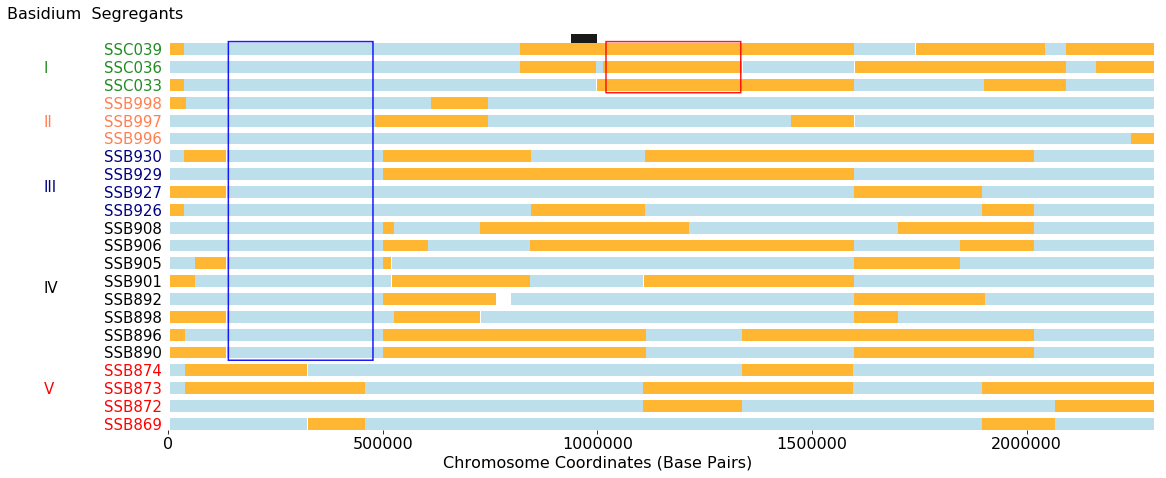

In [328]:
bas_levels = [6,23,40,51,60]
for ch, chrom in enumerate([chrlist[0]]):
    fig,ax = plt.subplots(1,1,figsize=(20,8));
    mod = 0;
    plt.xlim(-300000,clens[ch]);
    c = 0
    for s, Seg in enumerate(np.concatenate(tetras_used)):
        colour = colours[c]
        if s in np.array(len_sums)-1:
            c = c + 1
            ax.annotate(basidium_label[c-1],(-290000,bas_levels[c-1]),fontsize=15,color=colour)
        seg = hapdfs[ch][list(np.concatenate(tetras_used)).index(Seg)]
        x = zip(seg.v.tolist(),[nbs - 1 for nbs in seg.nb.tolist()]);
        fcolors = set_colors(seg.genotype.tolist());
        temp = Seg.split('_')[0]
        Seg_name = 'SS' + temp.split('-')[-1]
        ax.annotate(Seg_name,(-150000,s+mod),fontsize=15,color=colour) ## The Names of each segregant
        ax.broken_barh(x,[s+mod,2],facecolors=fcolors,alpha=.8);
        mod = mod + 2;
    ax.broken_barh([(centromere[0][chrom],centromere[1][chrom]-centromere[0][chrom])],
                    (s+mod,1.5),facecolors='black',alpha =.9); ## PLOT CENTROMERE
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.yaxis.set_visible(False);
    ax.spines['bottom'].set_bounds(0,clens[ch])
    ax.set_xticklabels(np.arange(-500000,clens[ch]+500000,500000),fontsize=16)
    ax.set_xlabel('Chromosome Coordinates (Base Pairs)',fontsize=16);
    plt.text(0.05, 1, 'Basidium  Segregants', horizontalalignment='center',verticalalignment='center',
                 transform = plt.gca().transAxes,fontsize=16,color=colours[1])
    ax.add_patch(FancyBboxPatch((140000,12),337000,53,fill=False,color='blue',alpha=0.9,linewidth=1.5));
    ax.add_patch(FancyBboxPatch((1020000,57),314000,8,fill=False,color='red',alpha=0.9,linewidth=1.5));
fig.savefig('../FIGS/Crypto-06-Wood-Floor-Basidia-%s-k1-6kb-Feb2018.png'%chrom,dpi=1200,bbox_inches='tight')

for ch, chrom in enumerate([chrlist[0]]):
    fig = plt.figure(figsize=(6,6));mod = 1;
    gs = gridspec.GridSpec(3,1, height_ratios=[.1,1,.1]);
    ax1 = fig.add_subplot(gs[0]);
    ## SNP DENSITY 
    ax1.bar(chromNwins[ch][:-1],chromNsnps[ch],width=ws,alpha=.5,color='olive');
    ax1.set_ylabel('Number of \nSNPs / %skb'%int(ws/1e3),fontsize=7);
    #ax1.set_ylim(0,)
    #SNP_max = my_round(max(chromNsnps[ch]));
    #assert SNP_max > max(chromNsnps[ch])
    #ax1.set_ylim(-1,SNP_max+50);
    ax1.spines['left'].set_position(('data', 0))
    ax = fig.add_subplot(gs[1])
    ax.broken_barh([(0,200000)],(0,1),facecolors='r',alpha=.7);
    ax.annotate('200kb',(0,-1.5),fontsize=8);
    for s, Seg in enumerate(np.concatenate(tetras)): ## What you are ploting 
        if Seg not in tetras:
            continue
        seg = hapdfs[ch][list(np.concatenate(tetras)).index(Seg)]
        x = zip(seg.v.tolist(),[nbs - 1 for nbs in seg.nb.tolist()]);
        fcolors = set_colors(seg.genotype.tolist());
        ax.annotate(Seg,(-400000,s+mod),fontsize=8) ## The Names of each segregant
        ax.broken_barh(x,[s+mod,1],facecolors=fcolors,alpha=.8);
        if s in tetra_index: ## if you change the number of segregants in each plot you need to alter these
            ax.hlines(s+mod+1.65,-500000,0,linestyles='--',linewidth=.5,alpha=.6)
        #if s == int(round((len(seg_un)-1)/2.0)):
        #    ax.annotate(r'$\alpha\  x\  \alpha$',(-500000,s+mod+1),rotation='vertical')
        #if s == int(len(seg_un)-1) + int(round((len(seg_bi)-1)/2.0)):
        #    ax.annotate(r'$\alpha\  x\  a$',(-500000,s+mod+1),rotation='vertical')
        mod = mod +1;
    ## PLOT CENTROMERE
    ax.broken_barh([(centromere[0][chrom],
                      centromere[1][chrom]-centromere[0][chrom])],
                    (s+mod,0.7),
                    facecolors='black',alpha =.9);
    ## PLOT MAT LOCUS
    if ch == 3:
        ax.broken_barh([(mats,
                      matst-mats)],
                    (s+mod,0.6),
                    facecolors='g',alpha =.9);
    ax2 = fig.add_subplot(gs[2])
    subbi = hotIMIdfbi[hotIMIdfbi.Chrom==chrom];
    subun = hotIMIdfun[hotIMIdfun.Chrom==chrom];
    bis = 1#39.0;
    uns=1#55.0
    subbi_rf = [int(subbi.XO[i])/float(bis) for i in subbi.index.tolist()]#[100*(subbi.XO[i]/bis)/float(subbi.IMI[i]) for i in subbi.index.tolist()]
    subbi_pos = subbi.Pos#[np.median([subbi.W[i],subbi.V[i]]) for i in subbi.index.tolist()]
    subun_rf = [int(subun.XO[i])/float(uns) for i in subun.index.tolist()]#[100*(subun.XO[i]/uns)/float(subun.IMI[i]) for i in subun.index.tolist()]
    subun_pos = subun.Pos#[np.mean([subun.W[i],subun.V[i]]) for i in subun.index.tolist()]
    ax2.plot(subbi_pos,subbi_rf,'k',alpha=.5);
    ax2.plot(subun_pos,subun_rf,'r',alpha=.5);
    #ax2.set_ylim(0,1);
    #ax2.set_ylim(0,max([max(subbi_rf),max(subun_rf)])+1);
    ax2.spines['left'].set_position(('data', 0))
    major_ticks = np.arange(0,max([max(subbi_rf),max(subun_rf)]),4);
    #ax2.set_yticks(major_ticks);
    ax2.set_ylabel('CO\nCounts',fontsize=8);
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
    ax.set_ylim(-2,);
    ax.set_xlim(-600000,clens[ch]+100000);
    ax1.set_xlim(-600000,clens[ch]+100000);
    ax2.set_xlim(-600000,clens[ch]+100000);
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax.axis('off')
    ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 
    ax2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
    plt.tight_layout();
    gs.update(wspace=0.001,hspace=0.0001)
    fig.savefig('../FIGS/Crypto-Wood-Floor-Basidia-%s-k1-6kb-Jan2018.png'%chrom,dpi=600)